<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_Python/blob/main/Colab_Notebook/02_07_03_04_survival_analysis_log_logistic_model_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 3.4 Log-Logistic Survival Model


The log-logistic model is a parametric survival model where the logarithm of survival time follows a logistic distribution. It is particularly useful for modeling survival data with non-monotonic hazard functions, making it suitable for various applications in medical research, reliability engineering, and economics.


## Overview


The **Log-Logistic survival model** is a parametric model in survival analysis where the logarithm of the survival time $T$, denoted $\ln(T)$, follows a logistic distribution. It is an Accelerated Failure Time (AFT) model, meaning covariates scale the survival time multiplicatively, accelerating or decelerating the time to an event (e.g., death, failure). The log-logistic model is particularly useful for modeling survival data with a non-monotonic hazard function that increases to a peak and then decreases, similar to the log-normal model, but it often has more tractable mathematical forms, including closed-form expressions for the survival and hazard functions.


#### Key Features


- **Hazard Function**: The hazard is typically non-monotonic, rising to a peak and then declining (arc-shaped) for shape parameter $p > 1$, or monotonically decreasing for $p \leq 1$. This makes it suitable for scenarios like post-treatment recovery, where risk initially increases (e.g., due to complications) and later decreases (e.g., as patients stabilize).
- **Applications**: Used in medical research (e.g., time to cancer relapse), reliability engineering (e.g., component lifetimes), and economics (e.g., duration of unemployment) when hazards are non-monotonic or decreasing.
- **Assumptions**: Assumes $\ln(T)$) follows a logistic distribution, implying  $T$ is log-logistically distributed. This is appropriate when empirical hazard plots (e.g., from Kaplan-Meier) show an arc-shaped or decreasing pattern.
- **Advantages**: Unlike the log-normal model, the log-logistic model has closed-form survival and hazard functions, making it easier to compute probabilities and hazard ratios. It can also fit into a proportional odds framework.
- **Limitations**: Not ideal for monotonically increasing hazards (use Weibull instead). May not capture complex hazard shapes as well as flexible models like generalized gamma.


- **Probability Density Function (PDF)**:

$$
  f(t) = \frac{p \lambda^p t^{p-1}}{(1 + (\lambda t)^p)^2}, \quad t > 0, \quad \lambda, p > 0
$$

 where $\lambda$ is the scale parameter, and $p$ is the shape parameter. The PDF describes the distribution of survival times, which is right-skewed.

- **Survival Function**:

$$
S(t) = \frac{1}{1 + (\lambda t)^p}
$$

  This gives the probability of surviving past time $t$. It decreases from $S(0) = 1$ to $S(\infty) = 0$.

- **Hazard Function**:

$$
  h(t) = \frac{f(t)}{S(t)} = \frac{p \lambda^p t^{p-1}}{1 + (\lambda t)^p}
$$
- For $p > 1$, the hazard increases to a peak at $t = \left( \frac{p-1}{\lambda^p p} \right)^{1/p}$ and then decreases.

  - For $p \leq 1$, the hazard is monotonically decreasing.
  
- **Mean and Variance** (for $p > 1$):

  - Mean: $E[T] = \frac{\pi / (p \lambda)}{\sin(\pi / p)}$
  
  - Variance: $\text{Var}(T) = \frac{2\pi / (p \lambda^2)}{\sin(2\pi / p)} - \left( \frac{\pi / (p \lambda)}{\sin(\pi / p)} \right)^2$
  
  - Note: The mean is undefined for $p \leq 1$.


### When to Use


Choose the log-logistic model when:

- Nonparametric hazard estimates (e.g., from Kaplan-Meier or kernel smoothing) show an arc-shaped or decreasing hazard.
- Survival times are positively skewed, and a logistic distribution for $\ln(T)$ is plausible.
- You need closed-form expressions for survival or hazard functions, unlike the log-normal model.
- You prefer an AFT model or a proportional odds framework to interpret covariate effects.


### Model Fit Assessment


- Use AIC/BIC to compare with other models (e.g., Weibull, log-normal).
- Check residuals (e.g., Cox-Snell) or compare fitted survival curves to Kaplan-Meier estimates.
- Validate the log-logistic assumption with Q-Q plots of log-times against a logistic distribution or hazard shape diagnostics.


## Cheeck and Load Required Packages

In [1]:
import subprocess
import sys

def install_and_import(package_name, import_name=None):
    """Install a package if not already installed and import it"""
    if import_name is None:
        import_name = package_name

    try:
        # Try to import the package
        globals()[import_name] = __import__(import_name)
        print(f"{package_name} is already installed")
    except ImportError:
        # If not installed, install it
        print(f"Installing {package_name}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
            globals()[import_name] = __import__(import_name)
            print(f"{package_name} installed successfully")
        except Exception as e:
            print(f"Failed to install {package_name}: {e}")
            raise

# List of packages to check/install
packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn', 'lifelines']

# Install and import each package
for pkg in packages:
    try:
        install_and_import(pkg)
    except Exception as e:
        print(f"Error with package {pkg}: {e}")

# Verify installation by importing
print("Installed packages:")
for pkg in packages:
    try:
        __import__(pkg)
        print(f"✓ {pkg}")
    except ImportError:
        print(f"✗ {pkg}")

pandas is already installed
numpy is already installed
matplotlib is already installed
seaborn is already installed
Installing scikit-learn...
Failed to install scikit-learn: No module named 'scikit-learn'
Error with package scikit-learn: No module named 'scikit-learn'
Installing lifelines...
lifelines installed successfully
Installed packages:
✓ pandas
✓ numpy
✓ matplotlib
✓ seaborn
✗ scikit-learn
✓ lifelines


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import LogLogisticAFTFitter, WeibullAFTFitter, LogNormalAFTFitter
from lifelines.statistics import logrank_test

import warnings
warnings.filterwarnings("ignore")

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

## Implementation in Python

### Data Preparation

In [3]:
url = "https://raw.githubusercontent.com/zia207/Survival_Analysis_Python/main/Data/lung_dataset.csv"
df = pd.read_csv(url)

df['sex'] = df['sex'].map({1: 0, 2: 1})           # 0=male, 1=female
df['event'] = (df['status'] == 1).astype(int)

# Drop rows with missing covariates (wt.loss has 14 missing, ph.ecog has 1)
df_clean = df.dropna(subset=['time', 'age', 'sex', 'ph.ecog', 'wt.loss']).copy()

# Create centered age (required for numerical stability and for predictions!)
df_clean['age_centered'] = df_clean['age'] - df_clean['age'].mean()

print(f"Observations used: {len(df_clean)} (cleaned dataset)")
print("No missing values:", df_clean[['time','event','age_centered','sex','wt.loss','ph.ecog']].isnull().sum().sum())

Observations used: 213 (cleaned dataset)
No missing values: 0


### Fit Log-Logistic AFT Model

In [4]:
# Fit Log-Logistic AFT
llogis_aft = LogLogisticAFTFitter()

llogis_aft.fit(df_clean,
               duration_col='time',
               event_col='event',
               formula="age_centered + sex + wt.loss + ph.ecog")

print("=== Log-Logistic AFT Model – Successfully Fitted ===")
llogis_aft.print_summary(decimals=3)

=== Log-Logistic AFT Model – Successfully Fitted ===


<lifelines.LogLogisticAFTFitter: fitted with 213 total observations, 151 right-censored observations>
             duration col = 'time'
                event col = 'event'
   number of observations = 213
number of events observed = 62
           log-likelihood = -469.882
         time fit was run = 2026-01-08 20:54:17 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                      
alpha_ Intercept     6.387   594.354     0.140           6.112           6.663             451.353             782.662
       age_centered  0.008     1.008     0.008          -0.008           0.023               0.992               1.023
       sex          -0.290     0.748     0.142          -0.569          -0.011               0.566               0.989
       wt.loss       0.003     1.003     0.006          -0.008           0.013               0.992               1.013
       ph.ecog       0.101     1.106     0.114          -0.123           0.324               0.885               1.382
beta_  Intercept     0.898     2.456     0.097           0.707           1.089               2.029               2.972

                     cmp to      z       p  -log2(p)
param  covariate                                    
alpha_ Intercept      0.000 45.487 <0.0005       inf
       age_centered   0.000  0.989   0.323     1.631
       sex            0.000 -2.040   0.041     4.597
       wt.loss        0.000  0.461   0.645     0.633
       ph.ecog        0.000  0.883   0.377     1.406
beta_  Intercept      0.000  9.221 <0.0005    64.884
---
Concordance = 0.596
AIC = 951.763
log-likelihood ratio test = 7.885 on 4 df
-log2(p) of ll-ratio test = 3.382

### Model Comparison with AIC

In [5]:
weibull_aft = WeibullAFTFitter()
lognormal_aft = LogNormalAFTFitter()

weibull_aft.fit(df_clean, duration_col='time', event_col='event',
                formula="age_centered + sex + wt.loss + ph.ecog")
lognormal_aft.fit(df_clean, duration_col='time', event_col='event',
                  formula="age_centered + sex + wt.loss + ph.ecog")

print("\n=== AIC Comparison (lower = better) ===")
print(f"Log-Logistic : {llogis_aft.AIC_:.2f}")
print(f"Weibull      : {weibull_aft.AIC_:.2f}")
print(f"Log-Normal   : {lognormal_aft.AIC_:.2f}")


=== AIC Comparison (lower = better) ===
Log-Logistic : 951.76
Weibull      : 953.37
Log-Normal   : 947.17


### Predictions

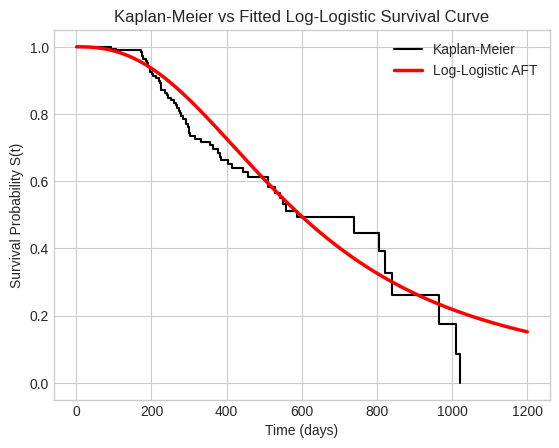

In [6]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(df_clean['time'], df_clean['event'])
ax = kmf.plot_survival_function(label="Kaplan-Meier", color="black", ci_show=False)

t = np.linspace(1, 1200, 400)

# Average patient (use same structure as training data!)
avg_patient = pd.DataFrame([{
    'age_centered': 0,
    'sex': df_clean['sex'].mean(),
    'wt.loss': df_clean['wt.loss'].median(),
    'ph.ecog': df_clean['ph.ecog'].median()
}])

S_t = llogis_aft.predict_survival_function(avg_patient, times=t)
ax.plot(t, S_t.iloc[:,0], label="Log-Logistic AFT", color="red", lw=2.5)

ax.set_title("Kaplan-Meier vs Fitted Log-Logistic Survival Curve")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Survival Probability S(t)")
ax.legend()
plt.show()

### Diagnostics

#### Q-Q Plot

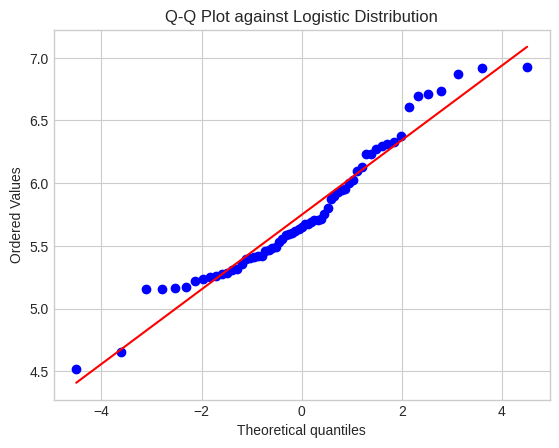

In [7]:
from scipy.stats import logistic, probplot
import numpy as np
import matplotlib.pyplot as plt

# Extract observed log-times for uncensored events
observed_logT = np.log(df[df['event'] == 1]['time'])

# Create Q-Q plot using logistic distribution
probplot(observed_logT, dist=logistic, plot=plt)
plt.title("Q-Q Plot against Logistic Distribution")
plt.show()

#### Cox-Snell Residuals

Number of residuals used: 37914


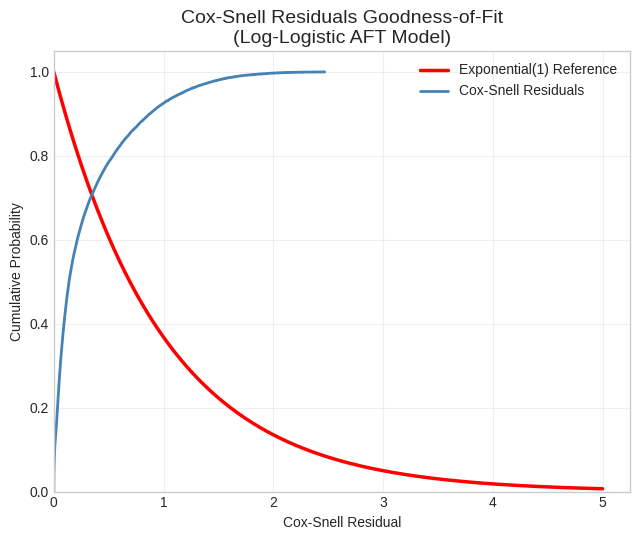

In [8]:
cumhaz = llogis_aft.predict_cumulative_hazard(df_clean)

# Extract as clean 1D numpy array
residuals_cs = cumhaz.values.flatten()  # or np.squeeze(cumhaz.values)

# === CRITICAL CLEANING STEP ===
# Remove any NaN or inf (shouldn't happen, but lifelines usually prevents it, but be safe)
residuals_cs = residuals_cs[~np.isnan(residuals_cs)]
residuals_cs = residuals_cs[~np.isinf(residuals_cs)]

# Sort (required by some ECDF implementations)
residuals_cs = np.sort(residuals_cs)

print(f"Number of residuals used: {len(residuals_cs)}")

# Now create ECDF safely
from statsmodels.distributions.empirical_distribution import ECDF
ecdf = ECDF(residuals_cs)

# Plot
plt.figure(figsize=(6.5, 5.5))
x_plot = np.linspace(0, max(5, residuals_cs.max() * 1.05), 300)
plt.plot(x_plot, np.exp(-x_plot), color='red', lw=2.5, label='Exponential(1) Reference')
plt.step(ecdf.x, ecdf.y, where='post', color='steelblue', lw=2, label='Cox-Snell Residuals')

plt.title("Cox-Snell Residuals Goodness-of-Fit\n(Log-Logistic AFT Model)", fontsize=14)
plt.xlabel("Cox-Snell Residual")
plt.ylabel("Cumulative Probability")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, None)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

#### Goodness-of-Fit and Hazard Plot

Available parameters:
MultiIndex([('alpha_',    'Intercept'),
            ('alpha_', 'age_centered'),
            ('alpha_',          'sex'),
            ('alpha_',      'wt.loss'),
            ('alpha_',      'ph.ecog'),
            ( 'beta_',    'Intercept')],
           names=['param', 'covariate'])
Shape parameter (λ) = 1.000


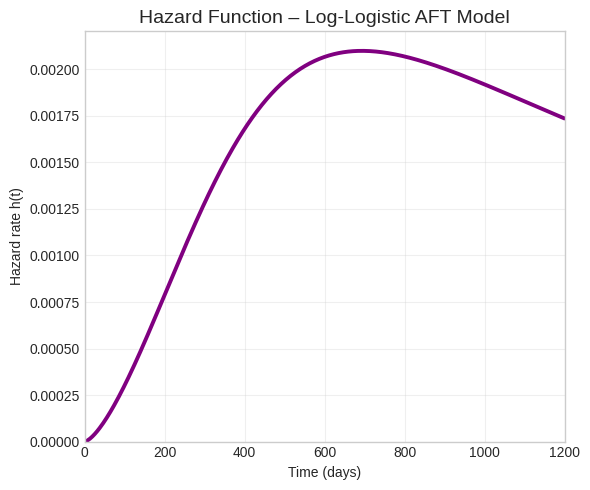

In [9]:
# Hazard Function Shape with Correct Parameter Name ---
hazard = llogis_aft.predict_hazard(avg_patient, times=t)

plt.figure(figsize=(6, 5))
plt.plot(t, hazard.iloc[:,0], color='purple', lw=2.8, label='Estimated hazard')
plt.title("Hazard Function – Log-Logistic AFT Model", fontsize=14)
plt.xlabel("Time (days)")
plt.ylabel("Hazard rate h(t)")
plt.grid(True, alpha=0.3)

# Extract the shape parameter correctly (new lifelines naming)
try:
    # New versions (lifelines ≥0.27): shape parameter is called 'lambda_'
    lambda_param = llogis_aft.params_.loc[('lambda_', 'lambda_')].values[0]
except KeyError:
    try:
        # Some versions use plain 'lambda_'
        lambda_param = llogis_aft.params_['lambda_'].iloc[0]
    except:
        # Fallback: print available params to debug
        print("Available parameters:")
        print(llogis_aft.params_.index)
        lambda_param = 1.0  # assume no peak

print(f"Shape parameter (λ) = {lambda_param:.3f}")

# Only plot peak if λ > 1 (non-monotonic hazard)
if lambda_param > 1:
    # Intercept of location (mu) parameter
    mu_intercept = llogis_aft.params_.loc[('mu_', 'Intercept')].values[0]

    # Time at which hazard peaks: t_peak = [(λ-1)/(λ * exp(μ))]^(1/λ)
    peak_time = ((lambda_param - 1) / (lambda_param * np.exp(mu_intercept))) ** (1 / lambda_param)

    peak_hazard = hazard.iloc[:,0].max()
    plt.axvline(peak_time, color='red', linestyle='--', lw=2,
                  label=f'Peak at {peak_time:.0f} days')
    plt.scatter([peak_time], [hazard.loc[peak_time].iloc[0]],
                color='red', s=80, zorder=5)
    plt.legend()

plt.xlim(0, t.max())
plt.ylim(0, None)
plt.tight_layout()
plt.show()

## Summary and Conclusion


This notebook demonstrated fitting a log-logistic survival model using Python, covering data preparation, model fitting, predictions, plotting, and diagnostics. The log-logistic model is suitable for survival data with non-monotonic or decreasing hazards and provides closed-form expressions for survival and hazard functions. Model diagnostics, including Q-Q plots and Cox-Snell residuals, help assess the fit and validate assumptions. Comparing AIC values with Weibull and log-normal models aids in selecting the best-fitting model.


## Resources


1. lifelines docs: https://lifelines.readthedocs.io

2. Book: "Modeling Survival Data in Python" (Davidson-Pilon)

3. Tutorial: https://github.com/zia207/Survival_Analysis_Python